# Experiment: Cohesion
To goal of cohesion is to maintain a cohesive collective whose network structure is neither too dense nor too sparse.

In [472]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from math import ceil

from matplotlib import rc
from IPython.display import HTML
import matplotlib.animation as animation

import math
import numpy as np
from interaction import Interaction
from environment import Environment
from fish import Fish
from channel import Channel
from observer import Observer
import pandas as pd

from scipy.spatial import distance
from utils import generate_distortion, generate_fish, run_simulation
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Player File Implementation
This file was obtained from stack overflow by theImportanceOfBeingEarnest

In [473]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import mpl_toolkits.axes_grid1
import matplotlib.widgets
#This file was originally published by ImportanceofBeingErnest in Stack Overflow

class Player(FuncAnimation):
    def __init__(self, fig, func, frames=None, init_func=None, fargs=None,
                 save_count=None, mini=0, maxi=100, pos=(0.125, 0.92), **kwargs):
        self.i = 0
        self.min=mini
        self.max=maxi
        self.runs = True
        self.forwards = True
        self.fig = fig
        self.func = func
        self.setup(pos)
        FuncAnimation.__init__(self,self.fig, self.func, frames=self.play(), 
                                           init_func=init_func, fargs=fargs,
                                           save_count=save_count, **kwargs )    

    def play(self):
        while self.runs:
            self.i = self.i+self.forwards-(not self.forwards)
            if self.i > self.min and self.i < self.max:
                yield self.i
            else:
                self.stop()
                yield self.i

    def start(self):
        self.runs=True
        self.event_source.start()

    def stop(self, event=None):
        self.runs = False
        self.event_source.stop()

    def forward(self, event=None):
        self.forwards = True
        self.start()
    def backward(self, event=None):
        self.forwards = False
        self.start()
    def oneforward(self, event=None):
        self.forwards = True
        self.onestep()
    def onebackward(self, event=None):
        self.forwards = False
        self.onestep()

    def onestep(self):
        if self.i > self.min and self.i < self.max:
            self.i = self.i+self.forwards-(not self.forwards)
        elif self.i == self.min and self.forwards:
            self.i+=1
        elif self.i == self.max and not self.forwards:
            self.i-=1
        self.func(self.i)
        self.fig.canvas.draw_idle()

    def setup(self, pos):
        playerax = self.fig.add_axes([pos[0],pos[1], 0.22, 0.04])
        divider = mpl_toolkits.axes_grid1.make_axes_locatable(playerax)
        bax = divider.append_axes("right", size="80%", pad=0.05)
        sax = divider.append_axes("right", size="80%", pad=0.05)
        fax = divider.append_axes("right", size="80%", pad=0.05)
        ofax = divider.append_axes("right", size="100%", pad=0.05)
        self.button_oneback = matplotlib.widgets.Button(playerax, label=u'$\u29CF$')
        self.button_back = matplotlib.widgets.Button(bax, label=u'$\u25C0$')
        self.button_stop = matplotlib.widgets.Button(sax, label=u'$\u25A0$')
        self.button_forward = matplotlib.widgets.Button(fax, label=u'$\u25B6$')
        self.button_oneforward = matplotlib.widgets.Button(ofax, label=u'$\u29D0$')
        self.button_oneback.on_clicked(self.onebackward)
        self.button_back.on_clicked(self.backward)
        self.button_stop.on_clicked(self.stop)
        self.button_forward.on_clicked(self.forward)
        self.button_oneforward.on_clicked(self.oneforward)

### using this class is as easy as using FuncAnimation:            


In [474]:
colors = [
    [230/255, 25/255, 75/255, 1.0],
    [60/255, 180/255, 75/255, 1.0],
    [255/255, 225/255, 25/255, 1.0],
    [0/255, 130/255, 200/255, 1.0],
    [245/255, 130/255, 48/255, 1.0],
    [145/255, 30/255, 180/255, 1.0],
    [70/255, 240/255, 240/255, 1.0],
    [240/255, 50/255, 230/255, 1.0],
    [210/255, 245/255, 60/255, 1.0],
    [250/255, 190/255, 190/255, 1.0],
    [0/255, 128/255, 128/255, 1.0],
    [230/255, 190/255, 255/255, 1.0],
    [170/255, 110/255, 40/255, 1.0],
    [255/255, 250/255, 200/255, 1.0],
    [128/255, 0/255, 0/255, 1.0],
    [170/255, 255/255, 195/255, 1.0],
    [128/255, 128/255, 0/255, 1.0],
    [255/255, 215/255, 180/255, 1.0],
    [0/255, 0/255, 128/255, 1.0],
    [128/255, 128/255, 128/255, 1.0],
    [0/255, 0/255, 0/255, 1.0],
]

### Initialize fish to for Local Triangle Formation

All robots start in the same place and have too many neighbors. They disperse to decrease their number of neighbors.

In [470]:
run_time = 30# in seconds
num_fish = 15
arena_size = [30,30]
arena_center = arena_size[0]/2
initial_spread = 15
fish_pos = np.zeros((num_fish,2))
fish_pos[:,0] = np.random.rand(num_fish)*(arena_size[0]/2)
fish_pos[:,1] = np.random.rand(num_fish)*(arena_size[0]/2)

clock_freqs = 1
verbose = False
orientation = [0,1]
distortion = generate_distortion(type='none', n=arena_size[0])
environment = Environment(
    node_pos=fish_pos,
    arena_size = arena_size,
    distortion=distortion,
    prob_type='binary', 
    noise_magnitude=0,
    conn_thres=30,
    verbose=verbose
)
interaction = Interaction(environment, verbose=verbose)
channel = Channel(environment)
formation_num = 1
fish = generate_fish(
    n=num_fish, 
    channel=channel, 
    orientation = orientation, 
    tolerance = 0.025,
    formation_num = formation_num, 
    fish_total_error = 0,
    interaction=interaction, 
    lim_neighbors=[0,30],
    neighbor_weights=1.0,
    fish_max_speeds=1,
    clock_freqs=clock_freqs,
    verbose=verbose
)
total_error =[]
channel.set_nodes(fish) 
observer = Observer(fish=fish, environment=environment, channel=channel)
run_simulation(fish=fish, observer=observer, run_time=run_time, dark=True, white_axis=False, no_legend=True)


Please wait patiently 30 seconds. Thanks.
total_error 0.0
total_error 0.0
total_error 3.0052495068954346
total_error 2.082874040465557
total_error 1.8163506360323893
total_error 1.5330170591000918
total_error 0.8756007945187305
total_error 0.8522095529126901
total_error 1.1551035554768718
total_error 1.2951633074720512
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
total_error 1.4189617205014515
It's time to say bye bye!


<IPython.core.display.Javascript object>


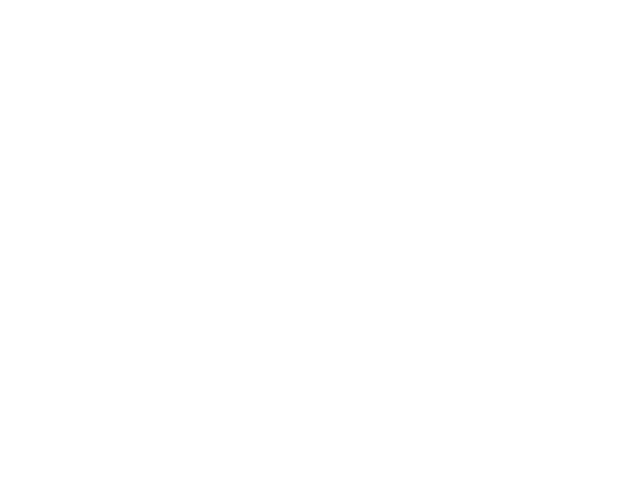

In [475]:
plt.figure(5)
plt.plot(observer.total_error[2:])

<IPython.core.display.Javascript object>


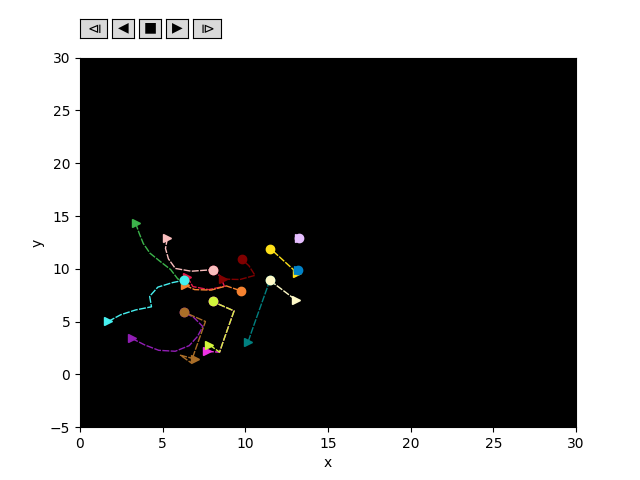

In [476]:
plt.ion()
plt.clf()
fig = plt.figure(1)
ax = plt.axes(xlim=(0, 30), ylim=(-5,30))
ax.set_facecolor('black')
ax.set_xlabel('x')
ax.set_ylabel('y')
N = observer.num_nodes
#fish = ax.plot( *([[], []]*N), marker=">",markersize =15,alpha = 1)
fish_pos1 = ax.plot( *([[], []]*N), linewidth=1, linestyle = (0, (5, 1)))
fish_pos2 = ax.plot( *([[], []]*N),marker='>')
fish_pos3 = ax.plot( *([[], []]*N),marker='o')  
fish_pos4 = ax.plot( *([[], []]*N),marker='o')
texts = [ax.text(0.80, 0.95-i*0.05,  '', transform=ax.transAxes) for i in range(N)]

def init():    
    for idx,line in enumerate(fish_pos1):
        line.set_data([], [])
        line.set_color(colors[idx])
    for idx,line in enumerate(fish_pos2):
        line.set_data([], [])
        line.set_color(colors[idx])
    for idx,line in enumerate(fish_pos3):
        line.set_data([], [])
        line.set_color(colors[idx])
    for line in fish_pos4:
        line.set_data([], [])
        line.set_color(colors[idx])
    return fish_pos1,fish_pos2


def animate(i):
    for j in range(N): 
        fish_pos1[j].set_data(observer.x[j][:i],observer.y[j][:i])
        fish_pos2[j].set_data(observer.x[j][0],observer.y[j][0])
        fish_pos3[j].set_data(observer.x[j][i-1],observer.y[j][i-1])
        #texts[j].set_text(observer.fish[j].id)
    return fish_pos1,fish_pos2, fish_pos3

anim = Player(fig, animate, init_func=init,
                       frames=20, interval=100, blit=True)
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#anim.save('local_static.mp4', writer=writer)
plt.show()
#print(observer.c[0])

### Initialize  Fish Fibonacci Global

All robots start in the same place and have too many neighbors. They disperse to decrease their number of neighbors.

In [425]:
from events import Move
run_time = 18# in seconds
num_fish = 10
arena_size = [30,30]
arena_center = arena_size[0]/2
initial_spread = 15
fish_pos = np.zeros((num_fish,2))
fish_pos[:,0] = np.random.rand(num_fish)*(arena_size[0]/2)
fish_pos[:,1] = np.random.rand(num_fish)*(arena_size[0]/2)

clock_freqs = 1
verbose = False
orientation = [1,1]
distortion = generate_distortion(type='none', n=arena_size[0])
environment = Environment(
    node_pos=fish_pos,
    arena_size = arena_size,
    distortion=distortion,
    prob_type='binary', 
    noise_magnitude=0,
    conn_thres=30,
    verbose=verbose
)
interaction = Interaction(environment, verbose=verbose)
channel = Channel(environment)
formation_num = 3
fish = generate_fish(
    n=num_fish, 
    channel=channel, 
    orientation = orientation, 
    formation_num = formation_num, 
    interaction=interaction, 
    lim_neighbors=[2,15],
    neighbor_weights=1.0,
    fish_max_speeds=1,
    clock_freqs=clock_freqs,
    verbose=verbose
)
channel.set_nodes(fish) 
migrate = Move(1,0)
observer = Observer(fish=fish, environment=environment, channel=channel)
#observer.instruct(event=migrate, rel_clock=0, fish_all=True)
run_simulation(fish=fish, observer=observer, run_time=run_time, dark=True, white_axis=False, no_legend=True)


TypeError: generate_fish() missing 2 required positional arguments: 'tolerance' and 'fish_total_error'

<IPython.core.display.Javascript object>


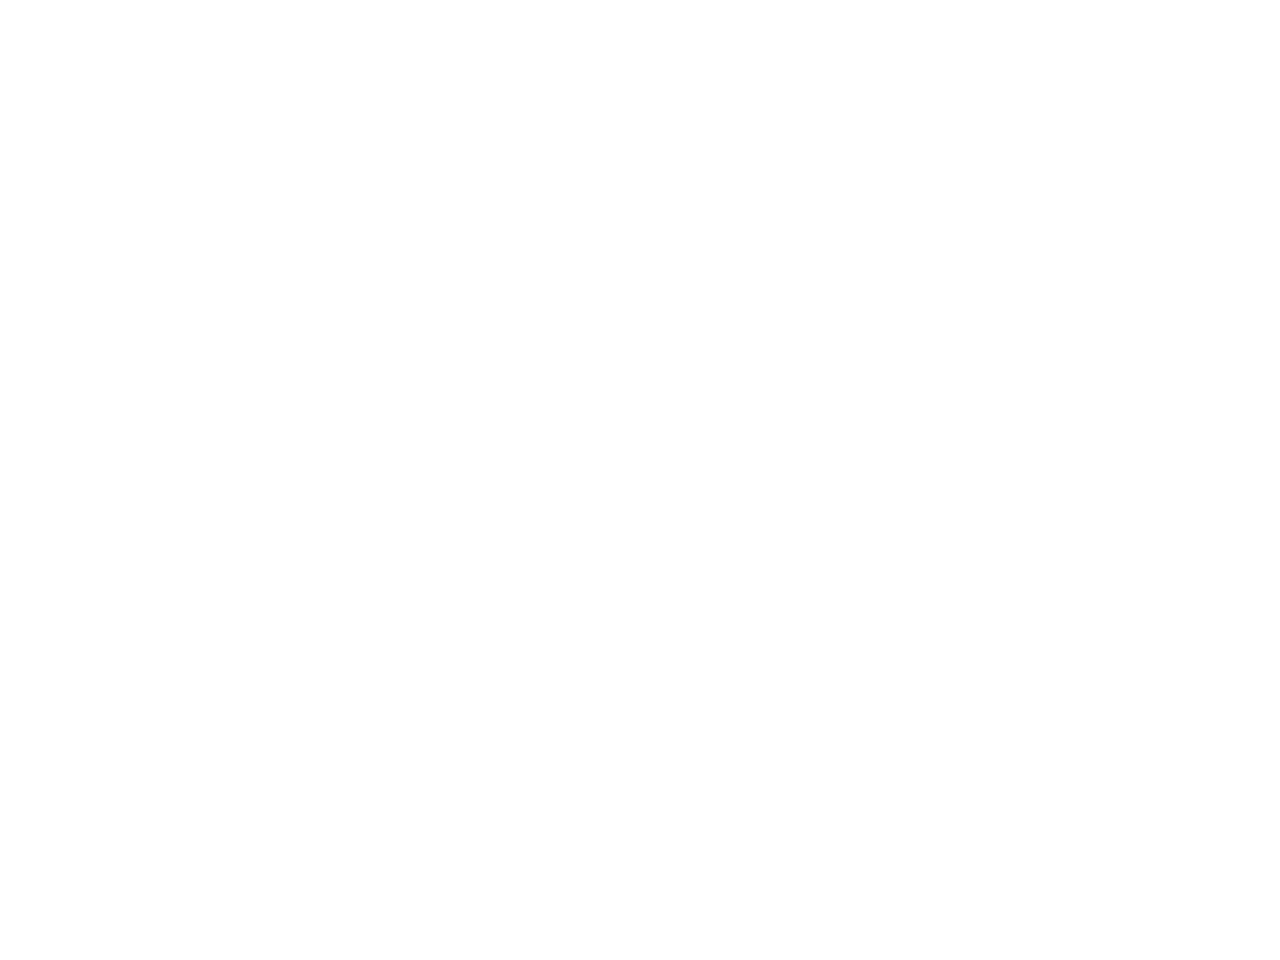

In [283]:
plt.ion()
plt.clf()
fig = plt.figure(2)
ax = plt.axes(xlim=(0, 30), ylim=(0,30))
ax.set_facecolor('black')
ax.set_xlabel('x')
ax.set_ylabel('y')
N = observer.num_nodes
#fish = ax.plot( *([[], []]*N), marker=">",markersize =15,alpha = 1)
fish_pos1 = ax.plot( *([[], []]*N), linewidth=1, linestyle = (0, (5, 1)))
fish_pos2 = ax.plot( *([[], []]*N),marker='>')
fish_pos3 = ax.plot( *([[], []]*N),marker='o')  
fish_pos4 = ax.plot( *([[], []]*N),marker='o')
texts = [ax.text(0.80, 0.95-i*0.05,  '', transform=ax.transAxes) for i in range(N)]

def init():    
    for idx,line in enumerate(fish_pos1):
        line.set_data([], [])
        line.set_color(colors[idx])
    for idx,line in enumerate(fish_pos2):
        line.set_data([], [])
        line.set_color(colors[idx])
    for idx,line in enumerate(fish_pos3):
        line.set_data([], [])
        line.set_color(colors[idx])
    for line in fish_pos4:
        line.set_data([], [])
        line.set_color(colors[idx])
    return fish_pos1,fish_pos2


def animate(i):
    for j in range(N): 
        fish_pos1[j].set_data(observer.x[j][:i],observer.y[j][:i])
        fish_pos2[j].set_data(observer.x[j][0],observer.y[j][0])
        fish_pos3[j].set_data(observer.x[j][i-1],observer.y[j][i-1])
        #texts[j].set_text(observer.fish[j].id)
    return fish_pos1,fish_pos2, fish_pos3

anim = Player(fig, animate, init_func=init,
                       frames=20, interval=100, blit=False)
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#anim.save('fibo_line.mp4', writer=writer)
plt.show()
#print(observer.c[0])

In [403]:
def F(i):
        return ((1+sqrt(5))**i-(1-sqrt(5))**i)/(2**i*sqrt(5))
def get_row_n(front_neighbors):
    my_index = front_neighbors+1
    f_i =0
    i =0
    while(f_i<my_index):
        f_i = F(i)
        i+=1
    return my_index-1, i-3,np.round(F(i-2)), np.round(F(i-1))



In [404]:
V4= [1,1]
V5 = [1,0]
np.dot(V4,V5)


1

      X         Y  dist
0   0.0  0.000000   0.0
1   1.0  0.000000   1.0
2   2.0  0.000000   2.0
3   3.0 -0.500000   3.0
4   3.0  0.500000   4.0
5   4.0 -1.000000   5.0
6   4.0  0.000000   6.0
7   4.0  1.000000   7.0
8   5.0 -2.000000   8.0
9   5.0 -1.000000   9.0
10  5.0  0.000000  10.0
11  5.0  1.000000  11.0
12  5.0  2.000000  12.0
13  6.0 -4.000000  13.0
14  6.0 -2.857143  14.0
15  6.0 -1.714286  15.0
16  6.0 -0.571429  16.0
17  6.0  0.571429  17.0
18  6.0  1.714286  18.0
19  6.0  2.857143  19.0
20  6.0  4.000000  20.0


<IPython.core.display.Javascript object>


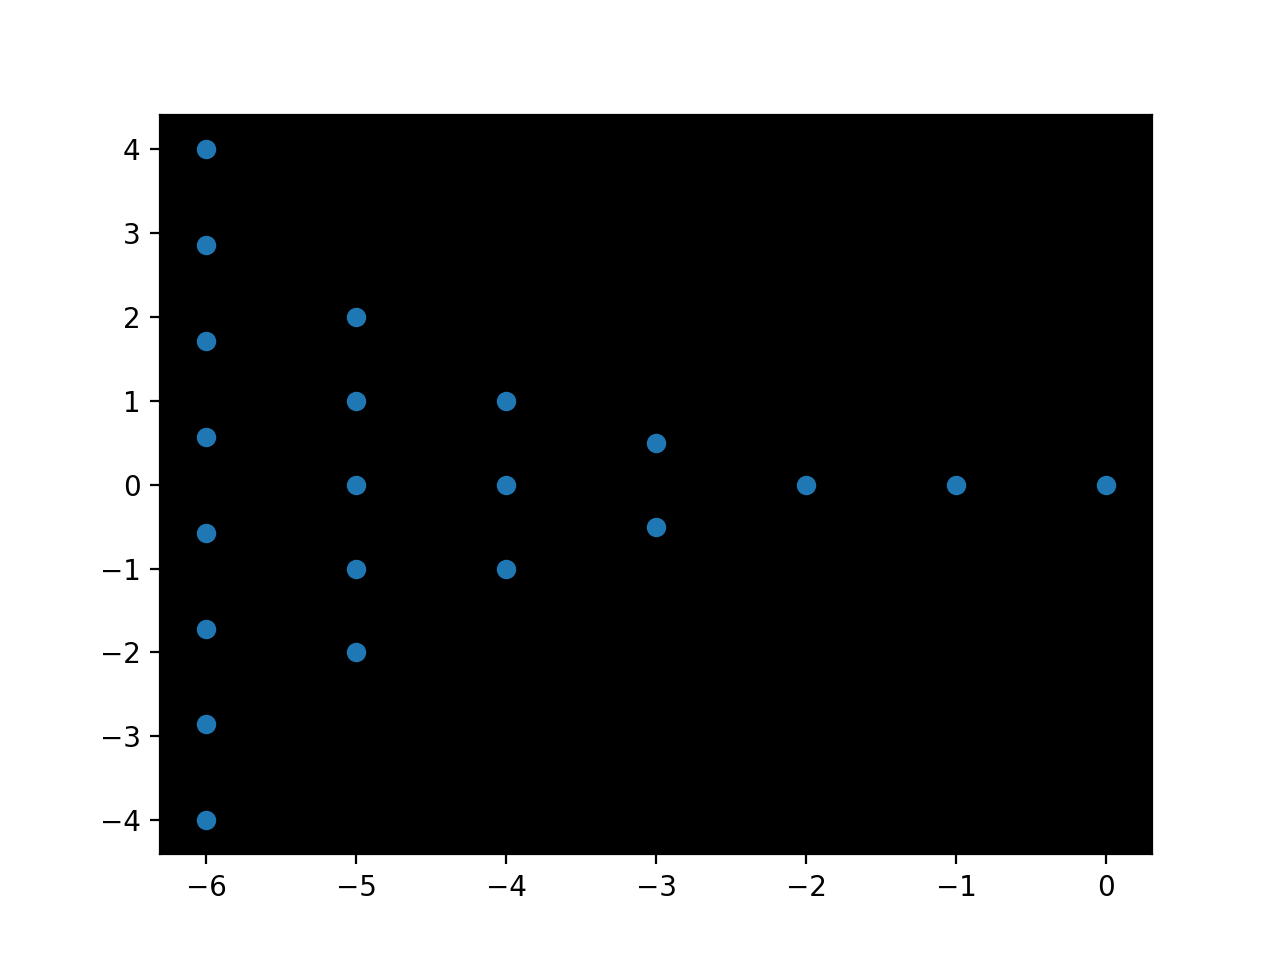

In [437]:
def fibonacci_formation(nfish,linespace):
    columns = ['X', 'Y', 'dist']
    index= np.arange(nfish)
    df= pd.DataFrame(index=index, columns=columns)
    df= df.fillna(0.0)
    #print(df)
    for i,row in df.iterrows():
        my_index, my_row, rs, re = get_row_n(i)
        if(my_row<=0):
            my_index =0
            my_row =0
        if(my_index in [0,1,2]):
            df.iloc[i]['X'] = my_row*linespace
            df.iloc[i]['dist'] = my_index
            df.iloc[i]['Y'] = 0

        else:
            df.iloc[i]['X'] = my_row*linespace
            df.iloc[i]['dist'] = my_index
            if(re-rs ==2):
                if(my_index==3):
                    df.iloc[i]['Y'] =-.5
                else:
                    df.iloc[i]['Y'] =.5
            elif((re-rs)%2==0):
                ys = np.linspace(-(re-rs)/2,int(re-rs)/2,int(re-rs))
                df.iloc[i]['Y'] = ys[int(my_index -rs)]
            else:
                df.iloc[i]['Y'] = ceil((re-rs)/2) - (re-my_index)
    return df
df = fibonacci_formation(21,1)
print(df)
fig = plt.figure(2)
plt.scatter(-df['X'], df['Y'])
plt.show()

      X         Y  dist
0   0.0  0.000000   0.0
1   1.0  0.000000   1.0
2   2.0  0.000000   2.0
3   3.0 -0.500000   3.0
4   3.0  0.500000   4.0
5   4.0 -1.000000   5.0
6   4.0  0.000000   6.0
7   4.0  1.000000   7.0
8   5.0 -2.000000   8.0
9   5.0 -1.000000   9.0
10  5.0  0.000000  10.0
11  5.0  1.000000  11.0
12  5.0  2.000000  12.0
13  6.0 -4.000000  13.0
14  6.0 -2.857143  14.0
15  6.0 -1.714286  15.0
16  6.0 -0.571429  16.0
17  6.0  0.571429  17.0
18  6.0  1.714286  18.0
19  6.0  2.857143  19.0
20  6.0  4.000000  20.0


<IPython.core.display.Javascript object>


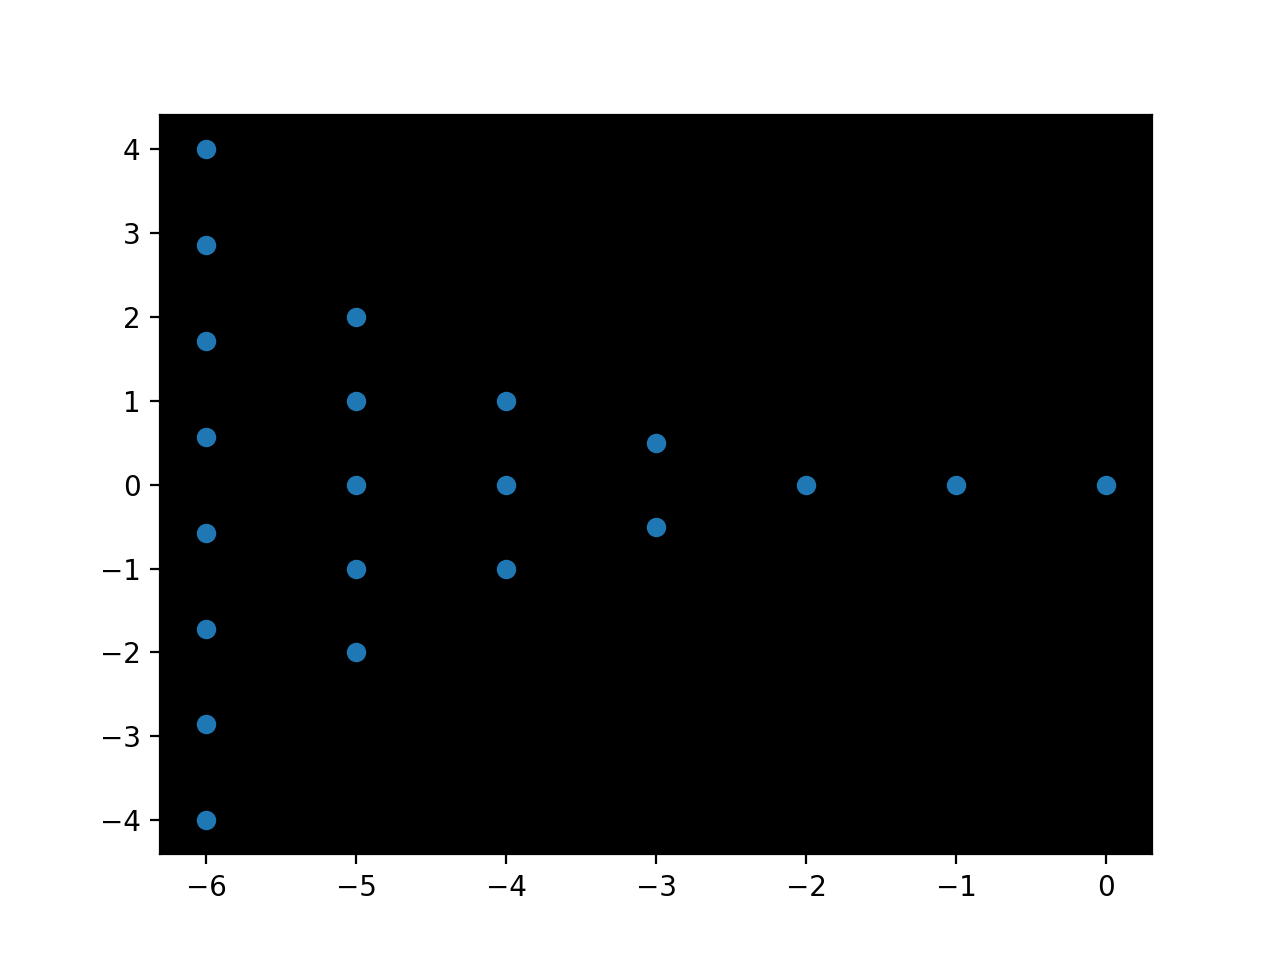

In [438]:
def define_target(rel_pos,target_map):
    target_map['X'] += my_leader_x
    target_map['Y'] += my_leader_y
    target_map['dist'] = np.sqrt( (target_map.X)**2 + (target_map.Y)**2)
    target_map = target_map.sort_values(['dist'],ascending =True)
    
    while(len(target_map)>0):
        my_target = [target_map.iloc[0]['X'],target_map.iloc[0]['Y']]
        my_dist = np.sqrt((my_target[0])**2 + (my_target[1])**2)
        df = pd.DataFrame.from_dict(rel_pos,orient = 'index', columns=['X', 'Y'])
        df['dist'] = np.sqrt( (df.X-my_target[0])**2 + (df.Y-my_target[1])**2)
        rel_pos = df.sort_values(['dist'],ascending =True)
        if(rel_pos.iloc[0]['dist']>=my_dist):
            return my_target
        else:
            target_map.drop(target_map.index[0]) 
    return my_target

print(df)
fig = plt.figure(4)
plt.scatter(-df['X'], df['Y'])
plt.show()

In [414]:
def generate_map(n_fish,map_type,linespace):
    if(map_type==0):
        df = fibonacci_formation(n_fish,linespace)
            
    elif(map_type==1):
        df = triangle_formation(n_fish,linespace)
    return df

<IPython.core.display.Javascript object>


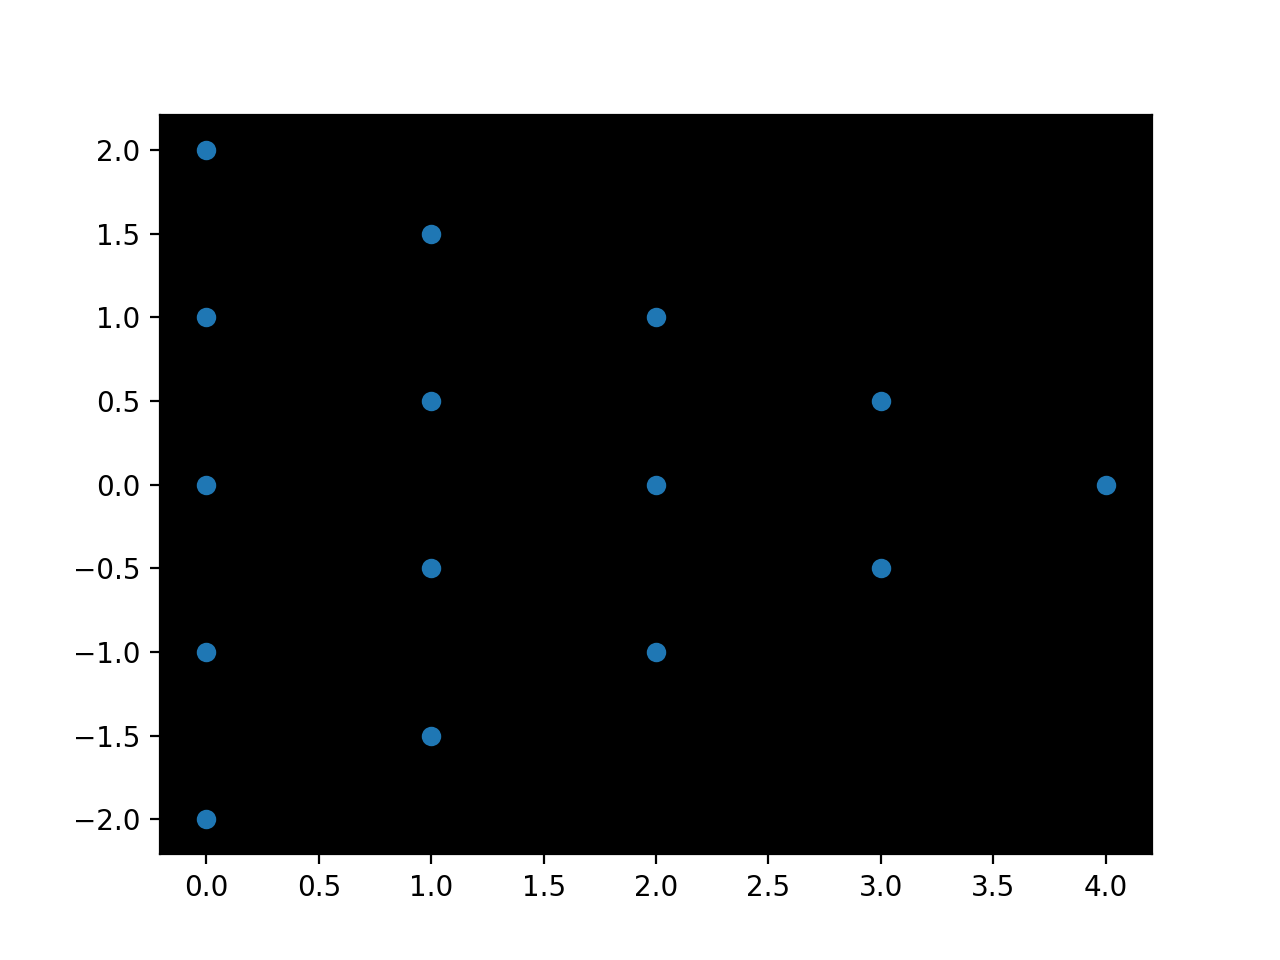

In [439]:
def triangle_formation(nfish,linespace):
    columns = ['X', 'Y', 'dist']
    index= np.arange(nfish)
    df= pd.DataFrame(index=index, columns=columns)
    df= df.fillna(0.0)
    for i,row in df.iterrows():
        my_index, my_row, rs, re = get_row_n2(i)
        df.iloc[i]['X'] = my_row*linespace
        df.iloc[i]['dist'] = my_index
        if(re-rs>0):
            ys = np.linspace(-(re-rs)/2,(re-rs)/2,int(re-rs)+1)
            df.iloc[i]['Y'] = ys[int(my_index-rs)]
    df['X'] = -df['X'] 
    df['X'] += my_row
    return df
df = triangle_formation(15,1)


fig = plt.figure(3)
plt.scatter(df['X'], df['Y'])
plt.show()

In [416]:
def T(i):
     return i*(i+1)/2

df = pd.DataFrame([[-4,6],[-2,2],[-2,]], columns = ['x','y'])

In [412]:
orientation = [0,1]
df = pd.DataFrame([[-4,7],[30,-30],[-2,1]], columns = ['x','y'])
df['cross'] = 0
for i,row in df.iterrows():
    row['cross'] = np.cross([row.x-orientation[0],row.x-orientation[1]], np.negative(orientation))
nr = df[df['cross']>0]
print(nr)

   x  y  cross
0 -4  7      4
2 -2  1      2


In [411]:
M =np.add([2,2],[4,2])/2
n = np.subtract([4,2], [2,2])
n = np.add(M,[n[1],-n[0]])


In [410]:
p = [0,1]
orientation = [0,1]

cross_p = np.cross([p[0]-orientation[0],p[1]-orientation[1]], orientation)
print(cross_p)

0


In [409]:
#end_not_inclusive this time
#row = number of els in this row 
#total number of els = n(n+1)
def get_row_n2(front_neighbors):
    if(front_neighbors==0):
        return 0,0,0,0
    else:
        my_index=front_neighbors 
        f_i =0
        i =1
        while(f_i<=my_index):
            f_i = T(i)
            i+=1        
        return my_index, i-2, T(i-1)-i+1,T(i)-(i+1)

        
    my_index = front_neighbors+1
    
print("res:",get_row_n2(0))
print("res:",get_row_n2(1))
print("res:",get_row_n2(2))
print("res:",get_row_n2(3))
print("res:",get_row_n2(4))
print("res:",get_row_n2(5))
print("res:",get_row_n2(6))
print("res:",get_row_n2(7))
print("res:",get_row_n2(8))
print("res:",get_row_n2(9))
print("res:",get_row_n2(10))
print("res:",get_row_n2(11))
print("res:",get_row_n2(12))
print("res:",get_row_n2(13))
print("res:",get_row_n2(14))
print("res:",get_row_n2(15))
print("res:",get_row_n2(16))
print("res:",get_row_n2(17))

res: (0, 0, 0, 0)


NameError: name 'T' is not defined

In [289]:
def align(rel_pos, linespace, r, fish_size):
    rel_pos = visible_neighbors(rel_pos, r, fish_size)
    xline = rel_pos[(rel_pos['X'] < linespace )& (rel_pos['X'] > -linespace)]
    avx = np.mean(xline['X'])
    return [avx,0]
print(align(rel_pos,0.3,2,.1))

[-0.1325365625, 0]


In [290]:
#x align 
xline = df[(df['X'] < .1 )& (df['X'] > -.1)]
avx = np.mean(xline['X'])
#average of x of my neighbors within such range
#if i have no neighbors in front 

### Aggregation in a counterclockwise curl
They robots start spread out and have too few neighbors. They aggregate to increase their number of neighbors. While doing so, they are affacted by a distortion of the type of a counterclockwise curl.

In [292]:
run_time = 5 # in seconds
num_fish = 50
arena_size = 30
arena_center = arena_size / 2.0
initial_spread = 25
fish_pos = initial_spread * np.random.rand(num_fish, 2) + arena_center - initial_spread / 2.0
clock_freqs = 1
verbose = False

distortion = generate_distortion(type='curl', n=arena_size)
environment = Environment(
    node_pos=fish_pos,
    distortion=distortion,
    prob_type='binary',
    noise_magnitude=0,
    conn_thres=10,
    verbose=verbose
)
interaction = Interaction(environment, verbose=verbose)
channel = Channel(environment)

fish = generate_fish(
    n=num_fish, 
    channel=channel, 
    interaction=interaction, 
    lim_neighbors=[math.inf,math.inf],
    neighbor_weights=1.0,
    fish_max_speeds=1,
    clock_freqs=clock_freqs,
    verbose=verbose
)
channel.set_nodes(fish)

observer = Observer(fish=fish, environment=environment, channel=channel)
run_simulation(fish=fish, observer=observer, run_time=run_time, dark=True, white_axis=False, no_legend=True)

Please wait patiently 5 seconds. Thanks.
It's time to say bye bye!


### Aggregation and migration
The robots start dispersed and gather first to then migrate from left to right. This is similar to salmons who come from different places in the ocean and then swim up their rivers of origin for reproduction.

In [ ]:
from events import Move

run_time = 20 # in seconds
num_fish = 25
arena_size = 30
arena_center = arena_size / 2.0
initial_spread = 10
fish_pos = np.zeros((num_fish,2))
fish_pos[:,0] = np.random.rand(num_fish) * initial_spread
fish_pos[:,1] = np.random.rand(num_fish) * initial_spread + arena_center - initial_spread/2
clock_freqs = 1
verbose = False

distortion = generate_distortion(type='none', n=arena_size)
environment = Environment(
    node_pos=fish_pos,
    distortion=distortion,
    prob_type='binary',
    noise_magnitude=0.2,
    conn_thres=10,
    verbose=verbose
)
interaction = Interaction(environment, verbose=verbose)
channel = Channel(environment)

fish = generate_fish(
    n=num_fish, 
    channel=channel, 
    interaction=interaction, 
    lim_neighbors=[math.inf,math.inf],
    neighbor_weights=1.0,
    fish_max_speeds=1,
    clock_freqs=clock_freqs,
    verbose=verbose
)
channel.set_nodes(fish)

observer = Observer(fish=fish, environment=environment, channel=channel)

migrate = Move(1,0)
observer.instruct(event=migrate, rel_clock=0, fish_all=True)

run_simulation(fish=fish, observer=observer, run_time=run_time, dark=True, white_axis=False, no_legend=True, no_star=True)